# UMAP visualization for CellProfiler features

In [110]:
import polars as pl
import umap.umap_ as umap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

CP_GALLERY_DIR = "../../../../2_analysis/3_cytoself/cellpainting_gallery"
batches = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]

## Loading data 

### The processed CP features

In [111]:
# # Filter thresholds
# min_area_ratio = 0.15
# max_area_ratio = 0.3
# min_center = 50
# max_center = 1030
# num_mad = 5
# min_cells = 250

batch_profiles = {}
profiles_df = pl.DataFrame()

for batch_id in batches:
    imagecsv_dir = f"{CP_GALLERY_DIR}/image_csv/cpg0020-varchamp/broad/workspace/assaydev/{batch_id}"
    prof_path = f"../snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet"
    # Get metadata
    profiles = pl.scan_parquet(prof_path)
    if (profiles_df.is_empty()):
        profiles_df = profiles.select(
            ["Metadata_well_position", "Metadata_plate_map_name", "Metadata_ImageNumber", "Metadata_ObjectNumber",
            "Metadata_symbol", "Metadata_gene_allele", "Metadata_control_type", "Metadata_Plate"] + \
            [col for col in profiles.columns if "GFP" in col or "DNA" in col],
        ).collect()
    else:
        select_cols = [col for col in profiles.columns if "GFP" in col or "DNA" in col]
        select_cols = ["Metadata_well_position", "Metadata_plate_map_name", "Metadata_ImageNumber", "Metadata_ObjectNumber",
                       "Metadata_symbol", "Metadata_gene_allele", "Metadata_control_type", "Metadata_Plate"] + \
                        [col for col in select_cols if col in profiles_df.columns]

        profiles_df = pl.concat([profiles_df.select(pl.col(select_cols)),  
                                profiles.select(
                                    select_cols
                                ).collect()])

### Loading the cells in the cytoself model

In [112]:
umap_df = pl.read_parquet("../../../3_cytoself/trained_models/varchamp_v2/analysis/umap_data/umap_comps_testdata.parquet")
umap_df = umap_df.with_columns(
    pl.col("Metadata_CellID").str.slice(11,2).alias("batch"),
    pl.col("Metadata_CellID").str.slice(23,3).alias("well_position"),
    pl.col("Metadata_Protein").str.split(by="-").list.get(0).alias("Gene"),
    (pl.when(pl.col("Metadata_Protein").str.contains("-"))
    .then(pl.lit("Allele"))
    .otherwise(pl.lit("Reference"))).alias("Allele_type")
)
cells = umap_df["Metadata_CellID"].unique().to_list()

### Get the overlapped cells for comparison

In [113]:
feat_cols = [col for col in profiles_df.columns if "Metadata_" not in col]
profiles_df_feat = profiles_df.with_columns(
    pl.concat_str(
        ['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber', 'Metadata_ObjectNumber'],
        separator="_").alias("Metadata_CellID")
    ).with_columns(pl.col(feat_col).fill_nan(None)).drop_nulls()
# Get profiles
dat = profiles_df_feat.filter(pl.col("Metadata_CellID").is_in(cells))

## UMAP visualization

In [114]:
gfp_colocal_feats = [col for col in dat.columns if "GFP" in col and "Corr" in col and "Brightfield" not in col]
len(gfp_colocal_feats)

39

In [115]:
n_neighbors=15
min_dist=0.1
metric='euclidean'
verbose=True

reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, verbose=verbose)
umap_data = reducer.fit_transform(dat.select(pl.col(gfp_colocal_feats)))

UMAP( verbose=True)
Mon Apr 14 00:27:19 2025 Construct fuzzy simplicial set
Mon Apr 14 00:27:19 2025 Finding Nearest Neighbors
Mon Apr 14 00:27:19 2025 Building RP forest with 18 trees
Mon Apr 14 00:27:19 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Mon Apr 14 00:27:22 2025 Finished Nearest Neighbor Search
Mon Apr 14 00:27:23 2025 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:28]

Mon Apr 14 00:27:53 2025 Finished embedding


In [116]:
umap_df = pl.DataFrame(umap_data, schema=["UMAP1", "UMAP2"])
umap_df = pl.concat([umap_df, dat], how="horizontal").with_columns(
    pl.col("Metadata_CellID").str.slice(11,2).alias("batch"),
    pl.col("Metadata_CellID").str.slice(23,3).alias("well_position"),
    pl.col("Metadata_gene_allele").str.split(by="_").list.get(0).alias("Gene")
    # (pl.when(pl.col("Metadata_gene_allele")=="disease_wt")
    # .then(pl.lit("Reference"))
    # .when(pl.col("Metadata_gene_allele")=="allele")
    # .then(pl.lit("Allele"))
    # .otherwise(pl.lit("Controls"))).alias("Allele_type")
)

In [117]:
hpa_subcell_loc = pl.read_csv("../../../3_cytoself/hpa_subcellular_location_annotations/subcellular_location_data.tsv", separator="\t")
# hpa_subcell_loc

umap_df_hpa = umap_df.join(hpa_subcell_loc, left_on="Gene", right_on="Gene name")
umap_df_hpa = umap_df_hpa.with_columns(
    pl.when(pl.col("Main location").str.contains(";"))
    .then(pl.lit("Multiple"))
    .otherwise(pl.col("Main location"))
    .alias("Subcell_Loc")
)

In [118]:
umap_df_hpa["Metadata_control_type"].unique()

Metadata_control_type
str
"""cPC"""
"""NC"""
"""allele"""
"""PC"""
"""disease_wt"""


In [119]:
umap_df_hpa.filter(
    (pl.col("Metadata_control_type")=="disease_wt")) ##&(pl.col("Additional location").is_not_null() &(pl.col("Subcell_Loc")!="Multiple")

UMAP1,UMAP2,Metadata_well_position,Metadata_plate_map_name,Metadata_ImageNumber,Metadata_ObjectNumber,Metadata_symbol,Metadata_gene_allele,Metadata_control_type,Metadata_Plate,Cytoplasm_RadialDistribution_MeanFrac_DNA_9of10,Nuclei_Texture_Correlation_GFP_20_02_256,Nuclei_Texture_Correlation_DNA_10_00_256,Nuclei_RadialDistribution_FracAtD_GFP_9of10,Cells_Correlation_RWC_Mito_DNA,Cytoplasm_RadialDistribution_MeanFrac_GFP_10of10,Nuclei_Texture_Correlation_DNA_20_01_256,Cells_Texture_InfoMeas1_DNA_20_01_256,Nuclei_Texture_InfoMeas2_DNA_5_02_256,Cytoplasm_RadialDistribution_MeanFrac_DNA_7of10,Nuclei_Correlation_Overlap_AGP_DNA,Cells_RadialDistribution_RadialCV_DNA_6of10,Cytoplasm_RadialDistribution_MeanFrac_GFP_6of10,Cells_Intensity_UpperQuartileIntensity_DNA,Nuclei_Texture_InfoMeas2_DNA_5_00_256,Cells_Granularity_6_DNA,Cytoplasm_Correlation_Correlation_Brightfield_DNA,Cytoplasm_RadialDistribution_FracAtD_GFP_1of10,Nuclei_Correlation_Correlation_Brightfield_L_DNA,Nuclei_RadialDistribution_RadialCV_DNA_7of10,Nuclei_RadialDistribution_RadialCV_GFP_10of10,Nuclei_Granularity_3_DNA,Cytoplasm_RadialDistribution_RadialCV_GFP_9of10,Cells_Texture_Correlation_GFP_20_01_256,Nuclei_Texture_Correlation_DNA_5_02_256,Nuclei_Correlation_K_DNA_Mito,Cells_Correlation_Correlation_AGP_GFP,…,Nuclei_Texture_SumVariance_DNA_20_00_256,Cytoplasm_Correlation_RWC_Brightfield_L_DNA,Nuclei_RadialDistribution_FracAtD_DNA_8of10,Nuclei_Intensity_MeanIntensityEdge_DNA,Nuclei_RadialDistribution_MeanFrac_DNA_6of10,Cells_Texture_Correlation_DNA_20_00_256,Cytoplasm_RadialDistribution_RadialCV_DNA_3of10,Nuclei_RadialDistribution_RadialCV_DNA_1of10,Nuclei_RadialDistribution_RadialCV_GFP_3of10,Cells_Granularity_5_DNA,Nuclei_Texture_InfoMeas2_DNA_10_03_256,Cells_Correlation_RWC_GFP_Mito,Cytoplasm_Texture_Correlation_GFP_10_03_256,Nuclei_Granularity_4_GFP,Cells_RadialDistribution_MeanFrac_GFP_6of10,Cytoplasm_Intensity_MaxIntensityEdge_DNA,Cells_Texture_Correlation_DNA_10_02_256,Nuclei_Intensity_MassDisplacement_DNA,Cells_Texture_InfoMeas1_GFP_10_00_256,Metadata_CellID,batch,well_position,Gene,Gene_right,Reliability,Main location,Additional location,Extracellular location,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id,Subcell_Loc
f32,f32,str,str,i64,i64,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
20.230715,4.773968,"""A04""","""B7A1R1_P1""",29,17,"""ANXA11""","""ANXA11""","""disease_wt""","""2024_01_17_B7A…",0.745145,10.155939,-1.472833,-0.651315,-0.972954,0.262503,-0.114888,-1.107237,-0.157227,-2.357817,0.23545,1.54124,-0.152922,6.134264,-1.111677,-0.490945,1.096813,0.787306,1.293614,0.695116,-1.038251,-0.461803,-1.317478,9.008121,-0.064389,-1.888766,-1.777514,…,-0.405699,-1.160385,-0.464124,0.95199,-0.013954,-1.658158,-0.316709,-1.61103,-0.798151,2.20502,-0.29189,-0.439225,2.564418,-1.013844,-0.656831,0.400534,0.104903,0.163178,1.0,"""2024_01_17_B7A…","""B7""","""A04""","""ANXA11""","""ENSG0000012235…","""Supported""","""Nucleoplasm""","""Cytosol;Vesicl…",null,null,"""Cytosol;Nucleo…","""Vesicles""",null,null,null,null,"""Cytosol (GO:00…","""Nucleoplasm"""
19.801699,5.265812,"""A04""","""B7A1R1_P1""",30,20,"""ANXA11""","""ANXA11""","""disease_wt""","""2024_01_17_B7A…",-0.636178,10.155939,1.19877,-0.418144,0.748558,0.445021,1.060764,0.715146,1.458293,-1.307657,-5.249037,-1.052528,-0.132515,25.165133,1.084269,11.319968,-0.303178,-0.720822,0.762748,3.981708,-0.274417,-0.772936,-1.273576,9.008121,1.70694,-0.78977,0.626356,…,3.019474,0.942925,1.078261,-0.667111,1.830212,-0.861124,-0.409591,-1.036502,-1.060236,2.96206,1.44961,-2.394309,2.564418,0.526107,0.040477,0.452108,0.53742,4.229624,1.0,"""2024_01_17_B7A…","""B7""","""A04""","""ANXA11""","""ENSG0000012235…","""Support

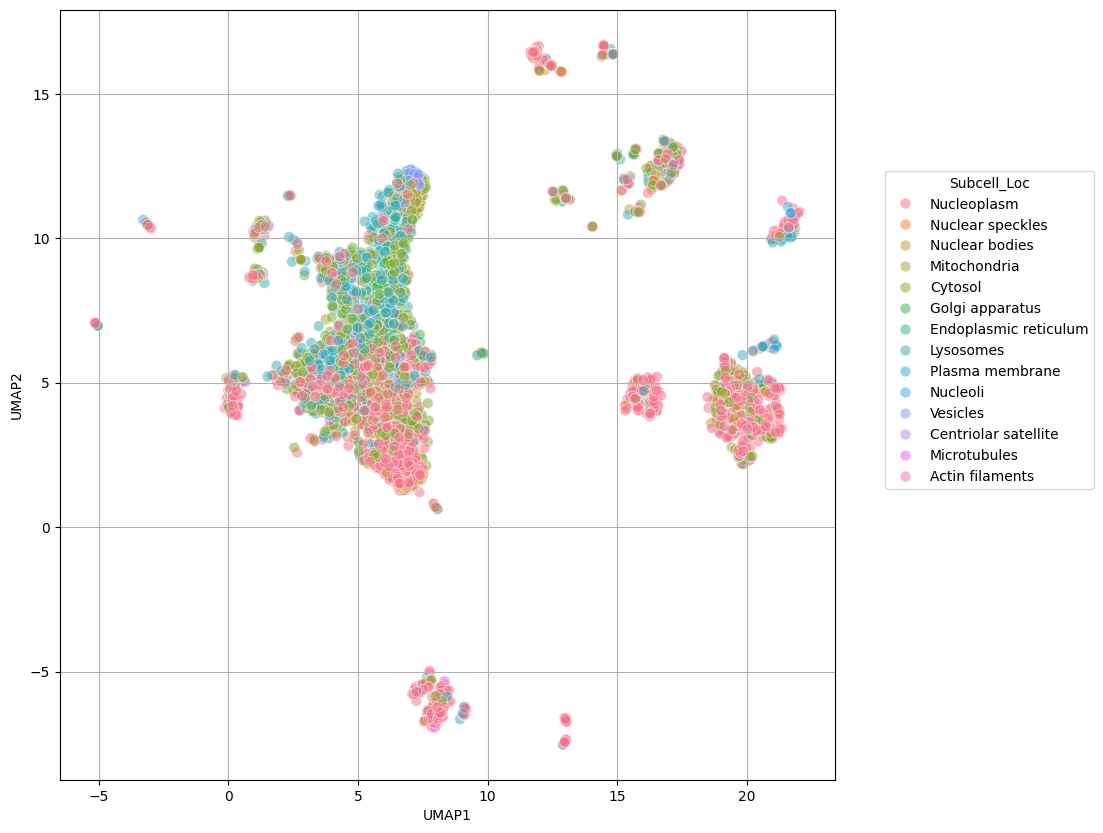

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.grid(True)

# umap_df = umap_df.with_columns(
#     pl.when(pl.col("Allele_type").is_in(list(list_unique_agxt)[:9]))
#     .then(pl.col("Metadata_Protein"))
#     .otherwise(pl.lit("000")).alias(f"{gene}_Variant")
# ).sort(f"{gene}_Variant")
# sns.scatterplot(umap_df_hpa.filter(pl.col("Allele_type") == "Allele"), x="UMAP1", y="UMAP2", color="grey", alpha=.1, ax=ax)
sns.scatterplot(umap_df_hpa.filter(
    (pl.col("Metadata_control_type")=="disease_wt")&(pl.col("Subcell_Loc")!="Multiple")&(pl.col("Additional location").is_not_null())
), x="UMAP1", y="UMAP2", hue="Subcell_Loc", palette="husl", ax=ax, s=60, alpha=0.5)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.5, .8, 1.4, 0))
leg._loc = 9

### Visualization by Gene

In [ ]:
def plot_gene_umap(umap_df, gene):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.grid(True)
    umap_df = umap_df.with_columns(
        pl.when(pl.col("Metadata_gene_allele").str.contains(gene))
        .then(pl.col("Metadata_gene_allele"))
        .otherwise(pl.lit("000")).alias(f"{gene}_Variant")
    ).sort(f"{gene}_Variant")
    
    sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") == "000"), x="UMAP1", y="UMAP2", color="grey", alpha=.1, ax=ax, s=50)
    sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") != "000"), x="UMAP1", y="UMAP2", hue=f"{gene}_Variant", style="batch", palette="Set2", ax=ax, s=50, alpha=0.7)

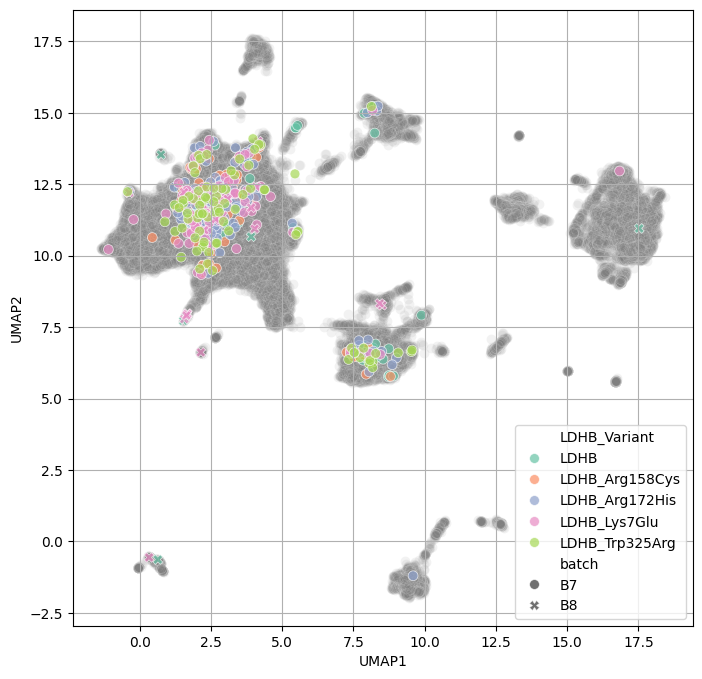

In [101]:
plot_gene_umap(umap_df, "LDHB")

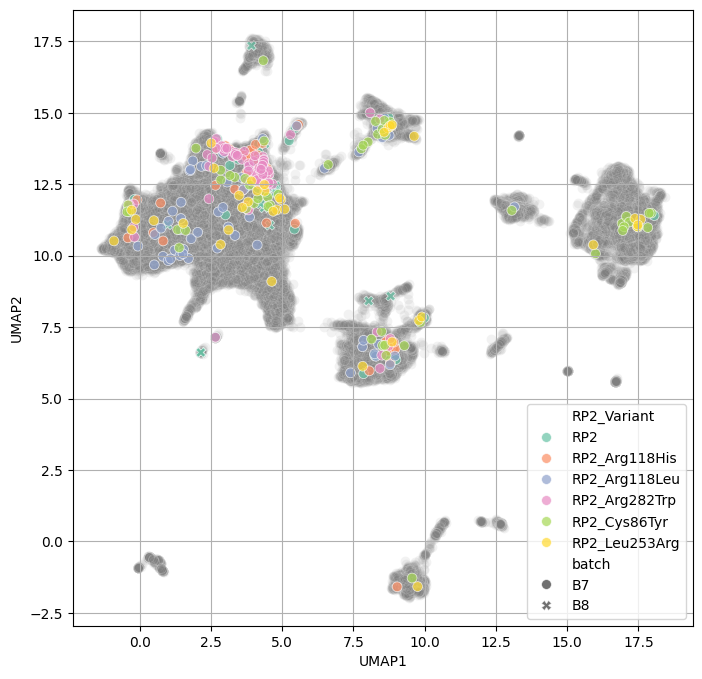

In [102]:
plot_gene_umap(umap_df, "RP2")